
#Drought Identification and Trend Analysis using Google Earth Engine (GEE) - Admin 1 Level

Author - Samuel Gartenstein

Date - Oct 2024

Version - 1.0


In [ ]:
pip install pymannkendall

In [ ]:
import ee
import geemap
import numpy as np
import pandas as pd
from scipy.stats import gamma, norm, kstest, probplot
import time
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
import pymannkendall as mk

In [ ]:
# Initialize Google Earth Engine
def initialize_ee():
    ee.Authenticate()
    ee.Initialize(project='ee-sg4283') #Change it to your project ID

initialize_ee()


### Define Analysis Boundaries

We use the following crop calendar to select the regions and time periods to focus on.

We define boundaries for the Western and Rift Valley, and Eastern and Northern Kenya. We use the FAO GAUL: Global Administrative Unit Layers for the analysis.

The Global Administrative Unit Layers (GAUL) compiles and disseminates the best available information on administrative units for all the countries in the world, providing a contribution to the standardization of the spatial dataset representing administrative units. The GAUL always maintains global layers with a unified coding system at country, first (e.g. departments), and second administrative levels (e.g. districts). Where data is available, it provides layers on a country by country basis down to third, fourth, and lowers levels.

**Note to self**: Add in clickable links


In [ ]:
# Load the FAO GAUL dataset for Zambia at administrative level 1
admin_level = 'level1'
country_name = 'Zambia'
roi = ee.FeatureCollection(f"FAO/GAUL/2015/{admin_level}")
roi = roi.filter(ee.Filter.eq('ADM0_NAME', country_name))

# Print the available counties (ADM1_NAME) for verification
counties_list = roi.aggregate_array('ADM1_NAME').getInfo()
print(counties_list)

['Central', 'Copperbelt', 'Eastern', 'Luapula', 'Lusaka', 'North-Western', 'Northern', 'Southern', 'Western']


In [ ]:
# Creating a map centered on Zambia
m = geemap.Map()
m.setCenter(27.8493, -13.1339, 6)  # Longitude, Latitude, and zoom level

# Add Zambia's Admin 1 boundaries as a layer
m.addLayer(roi, {"color": "green"}, "Zambia Admin 1 Boundaries")

# Display the map
m


Map(center=[-13.1339, 27.8493], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

# Load CHIRPS Pentad Dataset


In [ ]:
def fetch_precipitation_data(region_name):
    """
    Fetch monthly precipitation data for a given Admin Level 1 region in Zambia for 2022 to 2023,
    and return a restructured DataFrame with the following columns:
    - year, month, date, region, admin1_name, precipitation.
    """
    chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
    startyear, endyear = 2000, 2023  # Update to the years 2022 to 2023
    startdate, enddate = ee.Date.fromYMD(startyear, 1, 1), ee.Date.fromYMD(endyear, 12, 31)

    # Define the region from Zambia (Admin Level 1)
    region = ee.FeatureCollection('FAO/GAUL/2015/level1') \
              .filter(ee.Filter.eq('ADM0_NAME', 'Zambia')) \
              .filter(ee.Filter.eq('ADM1_NAME', region_name)).first()

    def MonthlySum(year):
        """
        Sum precipitation data for each month of a given year.
        """
        def monthSum(month):
            # Filter the CHIRPS dataset for the specific month and year
            monthly_sum = chirps.filterDate(startdate, enddate) \
                                .filter(ee.Filter.calendarRange(year, year, 'year')) \
                                .filter(ee.Filter.calendarRange(month, month, 'month')) \
                                .sum() \
                                .reduceRegion(ee.Reducer.mean(), geometry=region.geometry(), scale=5000, maxPixels=1e8)

            # Return the precipitation data and additional info
            return ee.Feature(None, {
                'year': year,
                'month': month,
                'date': ee.Date.fromYMD(year, month, 1).format(),
                'region': 'Zambia',  # Set as Zambia
                'admin1_name': region_name,  # Admin Level 1 region name
                'precipitation': monthly_sum.get('precipitation')
            })
        return ee.List.sequence(1, 12).map(monthSum)

    # List of years from 2022 to 2023
    years = ee.List.sequence(startyear, endyear)

    # Map over the years and fetch monthly precipitation
    monthlyPrecip = years.map(MonthlySum).flatten()

    # Convert the result to a FeatureCollection
    monthlyPrecipCollection = ee.FeatureCollection(monthlyPrecip)

    # Retrieve the result on the client side as a dictionary
    properties_list = monthlyPrecipCollection.getInfo()

    # Convert the result to a pandas DataFrame
    if properties_list['features']:
        data = [feature['properties'] for feature in properties_list['features']]
        df = pd.DataFrame(data)
    else:
        df = pd.DataFrame()

    # Define the restructure function inside the fetch function
    def restructure_dataframe(df):
        """
        Restructure the DataFrame to match the desired column order:
        ['year', 'month', 'date', 'region', 'admin1_name', 'precipitation']
        """
        desired_order = ['year', 'month', 'date', 'region', 'admin1_name', 'precipitation']
        df = df[desired_order]  # Ensure all columns are present in the DataFrame
        return df

    # Call the restructure function and return the restructured DataFrame
    return restructure_dataframe(df)



In [ ]:
# Fetch and store each region's DataFrame in individual variables
central_precip_data = fetch_precipitation_data('Central')
print(central_precip_data.head(12))
print(central_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia     Central     240.545614
1   2000      2  2000-02-01T00:00:00  Zambia     Central     255.378366
2   2000      3  2000-03-01T00:00:00  Zambia     Central     232.452149
3   2000      4  2000-04-01T00:00:00  Zambia     Central       9.756547
4   2000      5  2000-05-01T00:00:00  Zambia     Central       0.499351
5   2000      6  2000-06-01T00:00:00  Zambia     Central       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia     Central       0.000000
7   2000      8  2000-08-01T00:00:00  Zambia     Central       0.018995
8   2000      9  2000-09-01T00:00:00  Zambia     Central       0.002573
9   2000     10  2000-10-01T00:00:00  Zambia     Central      10.420805
10  2000     11  2000-11-01T00:00:00  Zambia     Central     119.177322
11  2000     12  2000-12-01T00:00:00  Zambia     Central     223.681583
     year  month                 date  region admin1_name  preci

In [ ]:
copperbelt_precip_data = fetch_precipitation_data('Copperbelt')
print(copperbelt_precip_data.head(12))
print(copperbelt_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia  Copperbelt     294.234393
1   2000      2  2000-02-01T00:00:00  Zambia  Copperbelt     257.580622
2   2000      3  2000-03-01T00:00:00  Zambia  Copperbelt     262.668946
3   2000      4  2000-04-01T00:00:00  Zambia  Copperbelt      12.032647
4   2000      5  2000-05-01T00:00:00  Zambia  Copperbelt       0.000000
5   2000      6  2000-06-01T00:00:00  Zambia  Copperbelt       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia  Copperbelt       0.000000
7   2000      8  2000-08-01T00:00:00  Zambia  Copperbelt       0.002427
8   2000      9  2000-09-01T00:00:00  Zambia  Copperbelt       0.008651
9   2000     10  2000-10-01T00:00:00  Zambia  Copperbelt      20.584498
10  2000     11  2000-11-01T00:00:00  Zambia  Copperbelt     154.918555
11  2000     12  2000-12-01T00:00:00  Zambia  Copperbelt     330.657782
     year  month                 date  region admin1_name  preci

In [ ]:
luapula_precip_data = fetch_precipitation_data('Luapula')
print(luapula_precip_data.head(12))
print(luapula_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia     Luapula     247.144670
1   2000      2  2000-02-01T00:00:00  Zambia     Luapula     214.376241
2   2000      3  2000-03-01T00:00:00  Zambia     Luapula     274.729209
3   2000      4  2000-04-01T00:00:00  Zambia     Luapula      52.603046
4   2000      5  2000-05-01T00:00:00  Zambia     Luapula       1.138437
5   2000      6  2000-06-01T00:00:00  Zambia     Luapula       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia     Luapula       0.000187
7   2000      8  2000-08-01T00:00:00  Zambia     Luapula       0.059572
8   2000      9  2000-09-01T00:00:00  Zambia     Luapula       1.191195
9   2000     10  2000-10-01T00:00:00  Zambia     Luapula      28.071444
10  2000     11  2000-11-01T00:00:00  Zambia     Luapula     171.096062
11  2000     12  2000-12-01T00:00:00  Zambia     Luapula     282.562261
     year  month                 date  region admin1_name  preci

In [ ]:
lusaka_precip_data = fetch_precipitation_data('Lusaka')
print(lusaka_precip_data.head(12))
print(lusaka_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia      Lusaka     211.499932
1   2000      2  2000-02-01T00:00:00  Zambia      Lusaka     229.132062
2   2000      3  2000-03-01T00:00:00  Zambia      Lusaka     181.584246
3   2000      4  2000-04-01T00:00:00  Zambia      Lusaka      10.481713
4   2000      5  2000-05-01T00:00:00  Zambia      Lusaka       0.242372
5   2000      6  2000-06-01T00:00:00  Zambia      Lusaka       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia      Lusaka       0.000000
7   2000      8  2000-08-01T00:00:00  Zambia      Lusaka       0.005142
8   2000      9  2000-09-01T00:00:00  Zambia      Lusaka       0.006372
9   2000     10  2000-10-01T00:00:00  Zambia      Lusaka      11.540079
10  2000     11  2000-11-01T00:00:00  Zambia      Lusaka      96.909930
11  2000     12  2000-12-01T00:00:00  Zambia      Lusaka     165.467175
     year  month                 date  region admin1_name  preci

In [ ]:
north_western_precip_data = fetch_precipitation_data('North-Western')
print(north_western_precip_data.head(12))
print(north_western_precip_data.tail(12))

    year  month                 date  region    admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia  North-Western     204.452954
1   2000      2  2000-02-01T00:00:00  Zambia  North-Western     198.768892
2   2000      3  2000-03-01T00:00:00  Zambia  North-Western     208.330116
3   2000      4  2000-04-01T00:00:00  Zambia  North-Western      14.904502
4   2000      5  2000-05-01T00:00:00  Zambia  North-Western       0.828444
5   2000      6  2000-06-01T00:00:00  Zambia  North-Western       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia  North-Western       0.000015
7   2000      8  2000-08-01T00:00:00  Zambia  North-Western       0.064161
8   2000      9  2000-09-01T00:00:00  Zambia  North-Western       2.429160
9   2000     10  2000-10-01T00:00:00  Zambia  North-Western      26.123517
10  2000     11  2000-11-01T00:00:00  Zambia  North-Western     138.518985
11  2000     12  2000-12-01T00:00:00  Zambia  North-Western     264.346358
     year  month         

In [ ]:
northern_precip_data = fetch_precipitation_data('Northern')
print(northern_precip_data.head(12))
print(northern_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia    Northern     216.502658
1   2000      2  2000-02-01T00:00:00  Zambia    Northern     189.500853
2   2000      3  2000-03-01T00:00:00  Zambia    Northern     244.090929
3   2000      4  2000-04-01T00:00:00  Zambia    Northern      48.428260
4   2000      5  2000-05-01T00:00:00  Zambia    Northern       3.017012
5   2000      6  2000-06-01T00:00:00  Zambia    Northern       0.002201
6   2000      7  2000-07-01T00:00:00  Zambia    Northern       0.000000
7   2000      8  2000-08-01T00:00:00  Zambia    Northern       0.040952
8   2000      9  2000-09-01T00:00:00  Zambia    Northern       0.720938
9   2000     10  2000-10-01T00:00:00  Zambia    Northern      24.687120
10  2000     11  2000-11-01T00:00:00  Zambia    Northern     185.598424
11  2000     12  2000-12-01T00:00:00  Zambia    Northern     267.622248
     year  month                 date  region admin1_name  preci

In [ ]:
southern_precip_data = fetch_precipitation_data('Southern')
print(southern_precip_data.head(12))
print(southern_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia    Southern     170.279557
1   2000      2  2000-02-01T00:00:00  Zambia    Southern     241.883281
2   2000      3  2000-03-01T00:00:00  Zambia    Southern     146.443345
3   2000      4  2000-04-01T00:00:00  Zambia    Southern      16.081653
4   2000      5  2000-05-01T00:00:00  Zambia    Southern       0.563035
5   2000      6  2000-06-01T00:00:00  Zambia    Southern       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia    Southern       0.000000
7   2000      8  2000-08-01T00:00:00  Zambia    Southern       0.000064
8   2000      9  2000-09-01T00:00:00  Zambia    Southern       0.032624
9   2000     10  2000-10-01T00:00:00  Zambia    Southern      12.328881
10  2000     11  2000-11-01T00:00:00  Zambia    Southern      76.468064
11  2000     12  2000-12-01T00:00:00  Zambia    Southern     176.965030
     year  month                 date  region admin1_name  preci

In [ ]:
western_precip_data = fetch_precipitation_data('Western')
print(western_precip_data.head(12))
print(western_precip_data.tail(12))

    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia     Western     186.183187
1   2000      2  2000-02-01T00:00:00  Zambia     Western     196.745684
2   2000      3  2000-03-01T00:00:00  Zambia     Western     218.633670
3   2000      4  2000-04-01T00:00:00  Zambia     Western      17.662483
4   2000      5  2000-05-01T00:00:00  Zambia     Western       0.080743
5   2000      6  2000-06-01T00:00:00  Zambia     Western       0.000000
6   2000      7  2000-07-01T00:00:00  Zambia     Western       0.000002
7   2000      8  2000-08-01T00:00:00  Zambia     Western       0.000036
8   2000      9  2000-09-01T00:00:00  Zambia     Western       0.267395
9   2000     10  2000-10-01T00:00:00  Zambia     Western      14.932101
10  2000     11  2000-11-01T00:00:00  Zambia     Western      67.325252
11  2000     12  2000-12-01T00:00:00  Zambia     Western     197.707636
     year  month                 date  region admin1_name  preci

In [ ]:
# Combine all three DataFrames into a single DataFrame
combined_df = pd.concat([
    central_precip_data,
    copperbelt_precip_data,
    luapula_precip_data,
    lusaka_precip_data,
    north_western_precip_data,
    northern_precip_data,
    southern_precip_data,
    western_precip_data
])

'''
TO DO: Export as CSV
'''


'\nTO DO: Export as CSV\n'

### Filtering for Rain Season

In the analysis, we are only interested in examining rainfall seasons. In Zambia, this takes place between November and March. As a result, I will filter `combined_df`.

In [ ]:
# Filter combined_df to include only months from November (11) to March (3)
zambia_rain_df = combined_df[combined_df['month'].isin([11, 12, 1, 2, 3])]

# Print the filtered combined DataFrame
print(zambia_rain_df.head(12))
print(zambia_rain_df.tail(12))


    year  month                 date  region admin1_name  precipitation
0   2000      1  2000-01-01T00:00:00  Zambia     Central     240.545614
1   2000      2  2000-02-01T00:00:00  Zambia     Central     255.378366
2   2000      3  2000-03-01T00:00:00  Zambia     Central     232.452149
10  2000     11  2000-11-01T00:00:00  Zambia     Central     119.177322
11  2000     12  2000-12-01T00:00:00  Zambia     Central     223.681583
12  2001      1  2001-01-01T00:00:00  Zambia     Central     263.590931
13  2001      2  2001-02-01T00:00:00  Zambia     Central     330.130325
14  2001      3  2001-03-01T00:00:00  Zambia     Central     216.453090
22  2001     11  2001-11-01T00:00:00  Zambia     Central     122.278114
23  2001     12  2001-12-01T00:00:00  Zambia     Central     198.752585
24  2002      1  2002-01-01T00:00:00  Zambia     Central     170.267318
25  2002      2  2002-02-01T00:00:00  Zambia     Central     102.782122
     year  month                 date  region admin1_name  preci

# Calculate Standardized Precipitation Index (SPI)

## SPI Definitions

* SPI1 (1-month scale)

Used to capture short-term monthly precipitation fluctuations and early warning of meteorological drought.

* SPI3 (3-month scale)

Useful for seasonal drought analysis, which helps in understanding the drought conditions over a quarterly period, closely related to agricultural impacts.

* SPI6 (6-month scale)

Provides insights into medium-term drought conditions, capturing both the end of one season and the start of another, which can influence soil moisture and crop yield over a longer period.

* SPI12 (12-month scale)

Used to assess long-term drought conditions, representing annual fluctuations and providing insights into the overall hydrological drought scenario, which can affect groundwater recharge and surface water availability.


## Selecting SPI Time Scales
Based on the above definitions we select the following time Scales for Long and Short Rains:

- Long Rains: March to June (4-month period) - We will use 1-month and 3-month SPI for long rains to understand short-term and medium-term droughts.
- Short Rains: October to December (3-month period) - We will use 1-month and 3-month SPI to capture variability within the shorter rainy season.

## Determining Gamma Distribution

What is a Gamma Distribution?

A gamma distribution is a type of statistical model used to describe data that are always positive and usually skewed, meaning most values are small but there can be a few large values. It's often used for things like rainfall, where:

- Many days have little or no rain, and
- A few days have a lot of rain.

This type of pattern creates a graph that has a high peak near the small values and a long tail extending to larger values. That’s what the gamma distribution looks like.

Why Do We Use Gamma Distribution for Rainfall?

- Always Positive: Rainfall cannot be negative; it either doesn’t rain or it rains some amount. The gamma distribution is great for representing only positive values.
- Right-Skewed Data: Most of the time, we have small amounts of rainfall, and occasionally, we get heavy rainfall. The gamma distribution is good for representing this kind of uneven distribution.
- Flexibility: The shape of the gamma distribution can change to fit different types of rainfall patterns, making it a very flexible tool for modeling different weather conditions.

The Gamma Distribution is the Standardized Precipitation Index (SPI) as a way to figure out if a place is having normal, dry, or wet weather compared to its history.

1. Modeling Historical Rainfall:

We use the gamma distribution to fit the historical rainfall data. This helps us understand what the usual rainfall is like for each month.

2. Comparing to Current Rainfall:

Once we have the gamma model of typical rainfall, we compare current rainfall to see how much it differs from the usual.
This comparison tells us if it is drier or wetter than normal, and by how much.

3. Getting SPI:

The final step is to convert this difference into a number called SPI, which tells us:
- If the SPI is negative, it means it’s drier than usual (possible drought).
- If the SPI is positive, it means it’s wetter than usual (possible flooding).

In [ ]:
# Checking if all precipitation values are positive in each dataset
print("Zambia Rainy Season: All values positive? ", (zambia_rain_df['precipitation'] > 0).all())

Zambia Rainy Season: All values positive?  True


### Histogram

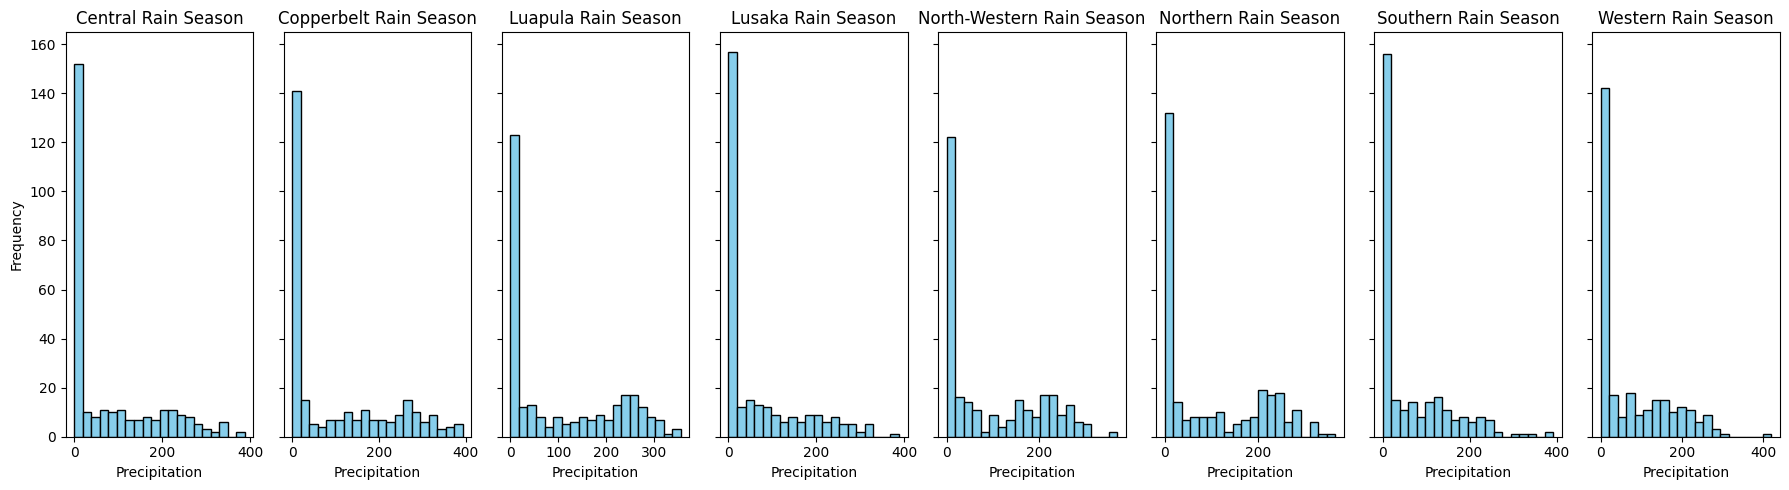

In [ ]:
# Get the list of unique Admin Level 1 regions (admin1_name) from the DataFrame
regions = combined_df['admin1_name'].unique()

# Set up the plot with one subplot per region (adjust rows and cols based on number of regions)
fig, axes = plt.subplots(1, len(regions), figsize=(18, 5), sharey=True)

# Loop through each region and plot the histogram
for i, region in enumerate(regions):
    # Filter the data for the current region
    region_data = combined_df[combined_df['admin1_name'] == region]

    # Plot histogram for the current region
    axes[i].hist(region_data['precipitation'], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{region} Rain Season')
    axes[i].set_xlabel('Precipitation')

    # Set ylabel only on the first plot
    if i == 0:
        axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

### Kolmogorov-Smirnov Test

Understanding the Kolmogorov-Smirnov Test:
The Kolmogorov-Smirnov test compares the empirical distribution of your data to a theoretical distribution (in this case, the gamma distribution).
The null hypothesis (H₀) of the KS test is that the data follows the specified distribution (in this case, gamma).
The alternative hypothesis (H₁) is that the data does not follow the specified distribution.

In the context of the Kolmogorov-Smirnov (KS) test, a p-value greater than 0.05 is typically desired when checking the fit of a distribution.

Interpreting the p-value:

- p-value > 0.05:
If the p-value is greater than 0.05, it means there is insufficient evidence to reject the null hypothesis.
In other words, the data fits the gamma distribution well. Therefore, we accept the null hypothesis and conclude that the gamma distribution is likely a good fit.

- p-value < 0.05:
If the p-value is less than 0.05, it means that there is significant evidence to reject the null hypothesis.
This suggests that the gamma distribution may not be a good fit for the data.

In [ ]:
def perform_ks_test(data, region_name):
    # Fit a gamma distribution to the data
    shape, loc, scale = gamma.fit(data, floc=0)  # floc=0 to ensure non-negative values

    # Perform Kolmogorov-Smirnov test
    test_stat, p_value = kstest(data, gamma(shape, loc, scale).cdf)

    # Print results for each region
    if p_value > 0.05:
        print(f"The data for {region_name} fits the gamma distribution well (p-value: {p_value:.4f}).")
    else:
        print(f"The gamma distribution may not be the best fit for {region_name} (p-value: {p_value:.4f}).")

# Perform KS test for each admin1_name
for region_name, group in zambia_rain_df.groupby('admin1_name'):
    print(f"Testing for {region_name}:")
    perform_ks_test(group['precipitation'].dropna(), region_name)
    print()  # Add a line break between region results


Testing for Central:
The data for Central fits the gamma distribution well (p-value: 0.2734).

Testing for Copperbelt:
The data for Copperbelt fits the gamma distribution well (p-value: 0.1277).

Testing for Luapula:
The data for Luapula fits the gamma distribution well (p-value: 0.0675).

Testing for Lusaka:
The data for Lusaka fits the gamma distribution well (p-value: 0.2682).

Testing for North-Western:
The data for North-Western fits the gamma distribution well (p-value: 0.1036).

Testing for Northern:
The gamma distribution may not be the best fit for Northern (p-value: 0.0025).

Testing for Southern:
The data for Southern fits the gamma distribution well (p-value: 0.9184).

Testing for Western:
The data for Western fits the gamma distribution well (p-value: 0.5949).



### Notes

All adminstrative zones pass the Perform Kolmogorov-Smirnov test.

### QQ Plots

A QQ plot, or Quantile-Quantile plot, is a graphical tool used to compare the distribution of a dataset with a theoretical distribution, such as the normal or gamma distribution. It's a provides a visual assessment of how well the dataset fits a chosen probability distribution. The QQ plot compares the quantiles of the dataset with the quantiles of the specified theoretical distribution.

If the data follows the theoretical distribution closely, the points on the plot will align approximately along a straight line. Deviations from this line indicate that the data does not conform well to the expected distribution.

In [ ]:
# Create a dictionary that dynamically extracts data for each region (admin1_name)
data_dict = {region: group['precipitation'].dropna() for region, group in zambia_rain_df.groupby('admin1_name')}

def interactive_qq_plot(region_name):
    """
    Generates a QQ plot for the selected region using a gamma distribution.

    Parameters:
    region_name (str): The key to select the dataset from the data dictionary.
    """
    # Extract the data series from the dictionary based on the selected region
    data = data_dict[region_name]

    # Fit the gamma distribution
    shape, loc, scale = gamma.fit(data, floc=0)

    # Generate QQ plot
    plt.figure(figsize=(8, 6))
    probplot(data, dist="gamma", sparams=(shape, loc, scale), plot=plt)
    plt.title(f"QQ Plot to Check Gamma Fit: {region_name}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Ordered Values")
    plt.grid(True)
    plt.show()

# Create an interactive dropdown widget for selecting the region
interact(
    interactive_qq_plot,
    region_name=Dropdown(
        options=list(data_dict.keys()),
        description='Select Region:',
        style={'description_width': 'initial'},
    )
)

interactive(children=(Dropdown(description='Select Region:', options=('Central', 'Copperbelt', 'Luapula', 'Lus…

<function __main__.interactive_qq_plot(region_name)>

### Analysis:

## Calculate SPI

In [ ]:
def calculate_spi(precip_series, scale=1):
    """
    Calculate Standardized Precipitation Index (SPI) for a given precipitation series.

    Parameters:
    precip_series (pd.Series): Precipitation data (assumed monthly in this case).
    scale (int): Time scale over which to calculate SPI (e.g., 1-month, 3-month).

    Returns:
    pd.Series: SPI values for the given precipitation series.
    """
    # Calculate rolling sum over the specified time scale
    precip_rolling = precip_series.rolling(window=scale).sum()

    # Drop NaN values resulting from the rolling operation
    precip_rolling = precip_rolling.dropna()

    # Fit a gamma distribution to the rolling sum data
    shape, loc, scale_param = gamma.fit(precip_rolling, floc=0)

    # Calculate cumulative distribution function (CDF) for gamma distribution
    gamma_cdf = gamma.cdf(precip_rolling, shape, loc=loc, scale=scale_param)

    # Convert gamma CDF to standard normal distribution to calculate SPI
    spi_values = norm.ppf(gamma_cdf)

    # Return the SPI values as a pandas Series with the same index
    return pd.Series(spi_values, index=precip_rolling.index)

# Initialize an empty DataFrame to store the SPI results across regions
spi_results_df = pd.DataFrame()

# Group by 'admin1_name' and process each region separately
admin1_names = zambia_rain_df['admin1_name'].unique()

for admin1 in admin1_names:
    # Clean the admin1_name to avoid spaces and special characters
    admin1_cleaned = admin1.replace(" ", "_").replace("-", "_")

    # Filter data for the current admin1_name and remove duplicate dates by aggregating the precipitation values
    region_data = zambia_rain_df[zambia_rain_df['admin1_name'] == admin1][['date', 'precipitation']]
    region_data.set_index('date', inplace=True)
    region_data = region_data.groupby(region_data.index).mean()  # Aggregate by mean to remove duplicate indices

    # Calculate 1-month SPI
    spi_1_month = calculate_spi(region_data['precipitation'], scale=1)
    spi_1_month.name = f'{admin1_cleaned}_1_month'

    # Calculate 3-month SPI
    spi_3_month = calculate_spi(region_data['precipitation'], scale=3)
    spi_3_month.name = f'{admin1_cleaned}_3_month'

    # Combine the 1-month and 3-month SPI results into a single DataFrame
    region_spi_df = pd.concat([spi_1_month, spi_3_month], axis=1)

    # Concatenate the SPI results for the region horizontally (across columns)
    spi_results_df = pd.concat([spi_results_df, region_spi_df], axis=1)

# Display the SPI results
print("SPI Results for all regions (admin1_name):")
print(spi_results_df.head())


SPI Results for all regions (admin1_name):
                     Central_1_month  Central_3_month  Copperbelt_1_month  \
date                                                                        
2000-01-01T00:00:00         0.742688              NaN            0.806621   
2000-02-01T00:00:00         0.879131              NaN            0.434411   
2000-03-01T00:00:00         0.665915         1.210229            0.488080   
2000-11-01T00:00:00        -0.669386         0.470874           -0.845479   
2000-12-01T00:00:00         0.580720         0.261946            1.147566   

                     Copperbelt_3_month  Luapula_1_month  Luapula_3_month  \
date                                                                        
2000-01-01T00:00:00                 NaN         0.398810              NaN   
2000-02-01T00:00:00                 NaN        -0.091178              NaN   
2000-03-01T00:00:00            0.904257         0.778868         0.652567   
2000-11-01T00:00:00           -0

In [ ]:
spi_results_df.head(10)

,Central_1_month,Central_3_month,Copperbelt_1_month,Copperbelt_3_month,Luapula_1_month,Luapula_3_month,Lusaka_1_month,Lusaka_3_month,North_Western_1_month,North_Western_3_month,Northern_1_month,Northern_3_month,Southern_1_month,Southern_3_month,Western_1_month,Western_3_month
date,,,,,,,,,,,,,,,,
2000-01-01T00:00:00,0.742688,NaN,0.806621,NaN,0.398810,NaN,0.757622,NaN,0.035869,NaN,0.184438,NaN,0.526208,NaN,0.470692,NaN
2000-02-01T00:00:00,0.879131,NaN,0.434411,NaN,-0.091178,NaN,0.907359,NaN,-0.059364,NaN,-0.190473,NaN,1.226105,NaN,0.600967,NaN
2000-03-01T00:00:00,0.665915,1.210229,0.488080,0.904257,0.778868,0.652567,0.483771,1.106127,0.099818,-0.096740,0.536579,0.217620,0.250736,0.964657,0.857013,0.875992
2000-11-01T00:00:00,-0.669386,0.470874,-0.845479,-0.017004,-0.822556,-0.144406,-0.508038,0.420684,-1.205157,-0.803554,-0.247567,-0.091138,-0.793115,0.390848,-1.557757,0.069826
2000-12-01T00:00:00,0.580720,0.261946,1.147566,0.480456,0.882183,0.572781,0.323763,-0.005381,0.946586,-0.100421,0.816725,0.671046,0.598857,-0.052798,0.612601,0.076852
2001-01-01T00:00:00,0.952473,0.467260,1.678524,1.293089,1.711199,1.321534,0.636148,0.107236,1.577672,0.914368,1.474373,1.433967,0.008291,-0.192024,-0.145768,-0.521085
2001-02-01T00:00:00,1.498616,1.702753,1.088751,2.238617,0.338661,1.987788,1.636841,1.482768,0.555135,1.795449,-0.051156,1.552152,1.742795,1.251502,1.390720,0.917677
2001-03-01T00:00:00,0.508841,1.664097,1.018455,2.163706,0.190245,1.530576,0.457137,1.552286,0.322870,1.429154,-0.059091,0.941224,0.120270,1.023152,0.088813,0.659049
2001-11-01T00:00:00,-0.623173,0.858700,-0.666015,0.863503,-1.134397,-0.473648,-0.468744,1.019556,-0.954182,-0.112159,-2.184563,-1.611311,-0.086188,0.983406,-0.146055,0.658924


In [ ]:
# Interactive plotting function
def plot_spi(region_time_scale):
    # Extract the SPI series based on the selected region and time scale
    spi_series = spi_results_df[region_time_scale].dropna()

    # Plot the SPI values
    plt.figure(figsize=(10, 6))
    plt.plot(spi_series.index, spi_series, color='blue', linestyle='-', marker='o', label='SPI')
    plt.axhline(y=0, color='black', linestyle='--')  # Reference line at SPI=0
    plt.axhline(y=-1, color='red', linestyle='--', label='Mild Drought (SPI=-1)')
    plt.axhline(y=-1.5, color='orange', linestyle='--', label='Moderate Drought (SPI=-1.5)')
    plt.axhline(y=-2, color='darkred', linestyle='--', label='Severe Drought (SPI=-2)')

    plt.xlabel('Date')
    plt.ylabel('SPI Value')
    plt.title(f'Standardized Precipitation Index (SPI) for {region_time_scale}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Get the list of region_time_scale options from the DataFrame columns
region_time_scale_options = spi_results_df.columns.tolist()

# Create a dropdown widget for selecting the region and time scale
interact(
    plot_spi,
    region_time_scale=Dropdown(
        options=region_time_scale_options,
        description='Select Region & Scale:',
        style={'description_width': 'initial'},
    )
)

interactive(children=(Dropdown(description='Select Region & Scale:', options=('Central_1_month', 'Central_3_mo…

<function __main__.plot_spi(region_time_scale)>

## Identify Drought Events

To characterize droughts, we need to analyze the SPI values calculated previously to identify distinct drought events. This involves analyzing when SPI values fall below a threshold, like -1.0, to determine the duration, severity, and intensity of each drought event.

Definitions:

- Drought Event: A period during which SPI is below a defined threshold (e.g., SPI < -1.0 for moderate drought).
- Drought Duration: The number of months during which the SPI value stays below the threshold.
- Drought Severity: The sum of all SPI values during the drought period.
- Drought Intensity: Severity divided by duration, indicating how intense the drought is on average.

In [ ]:
def characterize_drought_events(spi_series, threshold=-1.0):
    """
    Identify and characterize drought events based on SPI values.

    Parameters:
    spi_series (pd.Series): Series of SPI values indexed by date.
    threshold (float): Threshold SPI value below which a drought event is identified (default: -1.0).

    Returns:
    pd.DataFrame: DataFrame containing drought events with columns for start, end, duration, severity, and intensity.
    """
    drought_events = []
    in_drought = False
    start_date = None
    severity = 0

    # Loop through each SPI value to identify drought events
    for date, spi_value in spi_series.items():
        if spi_value < threshold:
            # If we are not already in a drought, mark the start
            if not in_drought:
                in_drought = True
                start_date = date
                severity = spi_value
            else:
                # Accumulate severity if already in a drought
                severity += spi_value
        else:
            # If we exit a drought, calculate duration, severity, and intensity
            if in_drought:
                in_drought = False
                end_date = date
                duration = (end_date - start_date).days // 30  # Approximate duration in months
                intensity = severity / duration if duration > 0 else 0
                drought_events.append({
                    'start_date': start_date,
                    'end_date': end_date,
                    'duration_months': duration,
                    'severity': severity,
                    'intensity': intensity
                })

    # Handle the case where a drought is ongoing at the end of the series
    if in_drought:
        end_date = spi_series.index[-1]
        duration = (end_date - start_date).days // 30
        intensity = severity / duration if duration > 0 else 0
        drought_events.append({
            'start_date': start_date,
            'end_date': end_date,
            'duration_months': duration,
            'severity': severity,
            'intensity': intensity
        })

    # Convert to DataFrame
    return pd.DataFrame(drought_events)

## Identify Drought Events

To characterize droughts, we need to analyze the SPI values calculated previously to identify distinct drought events. This involves analyzing when SPI values fall below a threshold, like -1.0, to determine the duration, severity, and intensity of each drought event.

Definitions:

- Drought Event: A period during which SPI is below a defined threshold (e.g., SPI < -1.0 for moderate drought).
- Drought Duration: The number of months during which the SPI value stays below the threshold.
- Drought Severity: The sum of all SPI values during the drought period.
- Drought Intensity: Severity divided by duration, indicating how intense the drought is on average.

In [ ]:
def characterize_drought_events(spi_series, threshold=-1.0):
    """
    Identify and characterize drought events based on SPI values.

    Parameters:
    spi_series (pd.Series): Series of SPI values indexed by date.
    threshold (float): Threshold SPI value below which a drought event is identified (default: -1.0).

    Returns:
    pd.DataFrame: DataFrame containing drought events with columns for start, end, duration, severity, and intensity.
    """
    drought_events = []
    in_drought = False
    start_date = None
    severity = 0

    # Loop through each SPI value to identify drought events
    for date, spi_value in spi_series.items():
        if spi_value < threshold:
            # If we are not already in a drought, mark the start
            if not in_drought:
                in_drought = True
                start_date = date
                severity = spi_value
            else:
                # Accumulate severity if already in a drought
                severity += spi_value
        else:
            # If we exit a drought, calculate duration, severity, and intensity
            if in_drought:
                in_drought = False
                end_date = date
                duration = (end_date - start_date).days // 30  # Approximate duration in months
                intensity = severity / duration if duration > 0 else 0
                drought_events.append({
                    'start_date': start_date,
                    'end_date': end_date,
                    'duration_months': duration,
                    'severity': severity,
                    'intensity': intensity
                })

    # Handle the case where a drought is ongoing at the end of the series
    if in_drought:
        end_date = spi_series.index[-1]
        duration = (end_date - start_date).days // 30
        intensity = severity / duration if duration > 0 else 0
        drought_events.append({
            'start_date': start_date,
            'end_date': end_date,
            'duration_months': duration,
            'severity': severity,
            'intensity': intensity
        })

    # Convert to DataFrame
    return pd.DataFrame(drought_events)


In [ ]:
def characterize_drought_events(spi_series, threshold=-1.0):
    """
    Identify and characterize drought events based on SPI values.

    Parameters:
    spi_series (pd.Series): Series of SPI values indexed by date.
    threshold (float): Threshold SPI value below which a drought event is identified (default: -1.0).

    Returns:
    pd.DataFrame: DataFrame containing drought events with columns for start, end, duration, severity, and intensity.
    """
    drought_events = []
    in_drought = False
    start_date = None
    severity = 0

    # Ensure the index (dates) are in datetime format
    spi_series.index = pd.to_datetime(spi_series.index)

    # Loop through each SPI value to identify drought events
    for date, spi_value in spi_series.items():
        if spi_value < threshold:
            # If we are not already in a drought, mark the start
            if not in_drought:
                in_drought = True
                start_date = date
                severity = spi_value
            else:
                # Accumulate severity if already in a drought
                severity += spi_value
        else:
            # If we exit a drought, calculate duration, severity, and intensity
            if in_drought:
                in_drought = False
                end_date = date
                duration = (end_date - start_date).days // 30  # Approximate duration in months
                intensity = severity / duration if duration > 0 else 0
                drought_events.append({
                    'start_date': start_date,
                    'end_date': end_date,
                    'duration_months': duration,
                    'severity': severity,
                    'intensity': intensity
                })

    # Handle the case where a drought is ongoing at the end of the series
    if in_drought:
        end_date = spi_series.index[-1]
        duration = (end_date - start_date).days // 30
        intensity = severity / duration if duration > 0 else 0
        drought_events.append({
            'start_date': start_date,
            'end_date': end_date,
            'duration_months': duration,
            'severity': severity,
            'intensity': intensity
        })

    # Convert to DataFrame
    return pd.DataFrame(drought_events)

In [ ]:
# Identify drought events for each region and time scale
drought_characteristics = {}

for column in spi_results_df.columns:
    spi_series = spi_results_df[column].dropna()
    drought_characteristics[column] = characterize_drought_events(spi_series)

# Display drought characteristics for each region and time scale
for region_scale, drought_df in drought_characteristics.items():
    print(f"Drought Characteristics for {region_scale}:")
    print(drought_df)
    print()


Drought Characteristics for Central_1_month:
   start_date   end_date  duration_months  severity  intensity
0  2002-03-01 2002-12-01                9 -3.035019  -0.337224
1  2003-11-01 2003-12-01                1 -1.271511  -1.271511
2  2004-11-01 2004-12-01                1 -1.245279  -1.245279
3  2005-02-01 2005-12-01               10 -3.867938  -0.386794
4  2007-03-01 2007-11-01                8 -1.166413  -0.145802
5  2012-11-01 2012-12-01                1 -1.469489  -1.469489
6  2013-03-01 2013-12-01                9 -3.150699  -0.350078
7  2014-11-01 2014-12-01                1 -2.085139  -2.085139
8  2015-03-01 2015-12-01                9 -3.089838  -0.343315
9  2018-01-01 2018-02-01                1 -1.228232  -1.228232
10 2018-11-01 2018-12-01                1 -1.889641  -1.889641
11 2019-03-01 2020-01-01               10 -3.973641  -0.397364
12 2020-03-01 2020-12-01                9 -3.051336  -0.339037
13 2021-11-01 2021-12-01                1 -1.571568  -1.571568
14 2022-03

Note - The issue where drought durations exceed expected limits (e.g., durations exceeding 3 months for a "3-month SPI scale") arises from the way the drought characterization function is designed. Specifically, the function might be identifying prolonged drought events that span beyond a single season or multi-month drought events that are not being properly split when SPI values rise above the threshold.

Due to continuous negative SPI Values, the function currently identifies a drought event as continuing until the SPI rises above the threshold. If the SPI remains below the threshold for an extended period (even beyond a season), the function will count that entire period as a single drought event.

## Trend Analysis

The Mann-Kendall test is a non-parametric test used to identify trends in time series data. It is particularly useful for climate data, like SPI values, to determine if there's a significant increasing or decreasing trend in drought conditions over time. We will also use Sen’s slope estimator to determine the magnitude of the trends identified.

In [ ]:
def perform_trend_analysis(spi_series, time_scale):
    """
    Perform Mann-Kendall test and Sen's Slope Estimation for the given SPI series.

    Parameters:
    spi_series (pd.Series): Series of SPI values.
    time_scale (str): Time scale (e.g., '1_month', '3_month').

    Returns:
    dict: Dictionary containing trend, p-value, and Sen's slope.
    """
    # Drop NaN values
    spi_series = spi_series.dropna()

    # Perform Mann-Kendall Trend Test
    mk_result = mk.original_test(spi_series)

    # Extract trend, p-value, and Sen's slope
    trend = mk_result.trend
    p_value = mk_result.p
    sen_slope = mk_result.slope

    return {
        'time_scale': time_scale,
        'trend': trend,
        'p_value': p_value,
        'sen_slope': sen_slope
    }


In [ ]:
# Applying the Mann-Kendall Test and Sen's Slope Estimation
trend_analysis_results = {}

# Loop through the columns of spi_results_df and apply trend analysis
for column in spi_results_df.columns:
    time_scale = column.split('_')[-1]  # Extract time scale from the column name (e.g., '1_month', '3_month')
    spi_series = spi_results_df[column]

    # Perform trend analysis for each column (region and time scale)
    trend_analysis_results[column] = perform_trend_analysis(spi_series, time_scale)

# Convert results to DataFrame for better visualization
trend_analysis_df = pd.DataFrame(trend_analysis_results).T

# Display the trend analysis results
print("Trend Analysis Results (Mann-Kendall Test and Sen's Slope):")
print(trend_analysis_df)


Trend Analysis Results (Mann-Kendall Test and Sen's Slope):
                      time_scale       trend   p_value sen_slope
Central_1_month            month    no trend  0.221488 -0.003505
Central_3_month            month    no trend  0.095842 -0.004783
Copperbelt_1_month         month    no trend   0.18604 -0.003788
Copperbelt_3_month         month  decreasing  0.017895 -0.006021
Luapula_1_month            month    no trend  0.370277 -0.002148
Luapula_3_month            month  decreasing   0.01282 -0.006877
Lusaka_1_month             month    no trend  0.509217  -0.00204
Lusaka_3_month             month    no trend  0.499984 -0.001687
North_Western_1_month      month    no trend  0.337324 -0.002791
North_Western_3_month      month    no trend  0.113736 -0.003836
Northern_1_month           month    no trend  0.569133  0.001166
Northern_3_month           month    no trend  0.709784 -0.001105
Southern_1_month           month    no trend  0.118095 -0.004173
Southern_3_month           mon

### Notes: